# Tracking messages

Goal: run in parallel Max-Sum with noise and the RS equations and compute at each iteration:
- The histogram of rounded messages
- The distribution $p(f)$
- The distortion computed on the non-rounded beliefs
- The distortion computed on rounded beliefs

In [100]:
include("../code/headers.jl")
using LaTeXStrings

Pick graph size and connectivity

In [106]:
n = factorial(8)
k = 3
R = 1 .- 2 ./k
m_ = n*(1 .- R)
m = Int.(round.(m_))
m_

26880.0

Initalize

In [115]:
randseed = 123
rng = MersenneTwister(randseed)
algo = MS(maxiter=300, Tmax=1, gamma=0.0, sigma=1e-10)
Y = [rand(rng, [0,1], n) for mm in m]
src = [1 .- 2*y for y in Y]
msgs = [[Vector{Vector{Float64}}(undef,m) for it in 1:algo.maxiter] for _ in m]
beliefs = [[zeros(n) for it in 1:algo.maxiter] for _ in m]
graphs = Vector{FactorGraph}(undef,length(m))
free_energies = [zeros(algo.maxiter) for _ in m]
parities = [zeros(Int, algo.maxiter) for _ in m]
dist_indep = [zeros(algo.maxiter) for _ in m]
N = 50 
p_init = OffsetArray([r ∈ (-1,0,1) ? 1/3 : 0.0 for r in -N:N], -N:N)
p = [[p_init for it in 1:algo.maxiter+1] for _ in m];

Define function to update $p(f)$ and compute overlap on it 

In [116]:
function iter(p,K)
    k = K - 1
    p1 = copy(p)
    p1 .= 0.0
    N = lastindex(p1)-1
    for f = 1:N
        v1 = p[f+1]+p[f-1]
        v2 = reduce(+,(p[f1+1]+p[f1-1] for f1=f+1:N), init=0.0)
        v = (v1+v2)^k-v2^k
        p1[+f] = v/2
        p1[-f] = v/2
    end
    v1 = (p[1]+p[-1])/2
    v2 = sum(p[f1+1]+p[f1-1] for f1=1:N)
    p1[0] = (v1+v2)^k-v2^k
    p1 ./ sum(p1)
end

function overlap(p,k)
    O = 0.0
    N = lastindex(p)-1
    for f1=-N:N
        for f2=-N:N
            for s = (-1,1)
                O += p[f1]*p[f2]*0.5*(abs(f1+s)+abs(f2+s)-abs(f1+f2+s))
            end
        end
    end
    tmp = 0.0
    for f = 1:N-1
        v1 = p[f+1]+p[f-1]
        v2 = sum(p[f1+1]+p[f1-1] for f1=f+1:N)
        v = (v1+v2)^k-v2^k
        tmp += f*v
    end
    O -= tmp*2/k
    O
end

overlap (generic function with 1 method)

In [117]:
function init_msgs!(fg::FactorGraph, vals::Vector{<:Real})
   for j in eachindex(fg.mfv)
        fg.mfv[j] .= rand(vals, length(fg.mfv[j]))
    end    
end

init_msgs! (generic function with 1 method)

Store the whole history of messages, beliefs and message probabilities from the cavity equations

In [118]:
for j in eachindex(m)
    println("Rate $(round(R[j],digits=2)). $j of $(length(m))")
    fg = ldpc_graph(Val(2), n, m[j], randseed=randseed)
    extfields!(fg,Y[j],algo,randseed=randseed+j)
    indep = falses(fg.n); lb = lightbasis(fg, indep)
#     init_msgs!(fg, [-1,0,1])
    for it in 1:algo.maxiter
        mod(it,50)==0 && println("Finished iter ", it, " of ", algo.maxiter)
        onebpiter!(fg, algo)
        msgs[j][it] = copy(fg.mfv)
        beliefs[j][it] = copy(fg.fields)
        free_energies[j][it] = free_energy(fg)
        dist_indep[j][it] = fix_indep_from_ms(fg, Y[j], basis=lb, independent=indep)
        p[j][it+1] = iter(p[j][it], k[j])
        parities[j][it] = parity(fg)
    end
    graphs[j] = deepcopy(fg)
end

Rate 0.33. 1 of 1
Finished iter 50 of 300
Finished iter 100 of 300
Finished iter 150 of 300
Finished iter 200 of 300
Finished iter 250 of 300
Finished iter 300 of 300


In [119]:
dist_non_rounded = [zeros(algo.maxiter) for _ in m]
dist_rounded = [zeros(algo.maxiter) for _ in m]
dist_rs = [zeros(algo.maxiter) for _ in m]
msgs_rounded = [[Int[] for it in 1:algo.maxiter] for _ in m];

Compute distortions in 4 ways:
- Fixing independent variables to the (unrounded) decision variables (`Fix indep`) $\leftarrow$ The only one which is for sure relative to a codeword
- Naively, using the signs of the decision variables (`Non-rounded`)
- With the Free energy from the histogram of messages (`Free energy`)
- With the Free energy on the messages at the current RS equations iteration (`RS`)

In [120]:
decvars = zeros(n)
ovl = 0.0
ovl_rs = 0.0
for j in eachindex(m)
    for it in 1:algo.maxiter
        msgs_rounded[j][it] = round.(Int, reduce(vcat,msgs[j][it]))
        decvars .= sign.(beliefs[j][it])
        ovl = dot(decvars,src[j])/n
        dist_non_rounded[j][it] = 0.5*(1-ovl)
        dist_rounded[j][it] = 0.5*(1-free_energies[j][it]/n)
        ovl_rs = overlap(p[j][it+1],k[j])
        dist_rs[j][it] = 0.5*(1-ovl_rs)
    end
end

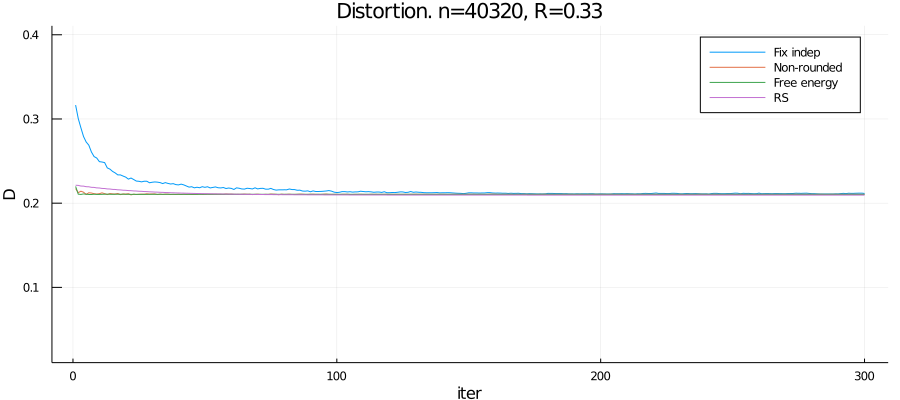

In [121]:
j = 1
pl = plot(1:algo.maxiter, dist_indep[j], label="Fix indep")
plot!(1:algo.maxiter, dist_non_rounded[j], label="Non-rounded")
title!("Distortion. n=$n, R=$(round(R[j],digits=2))"); xlabel!("iter"); ylabel!("D")
plot!(1:algo.maxiter, dist_rounded[j], label="Free energy")
plot!(1:algo.maxiter, dist_rs[j], label="RS", legend=:topright)
avg_dist = mean(dist_rs[j])
ylims!((avg_dist - 0.2, avg_dist + 0.2))
plot(pl, size=(900,400))

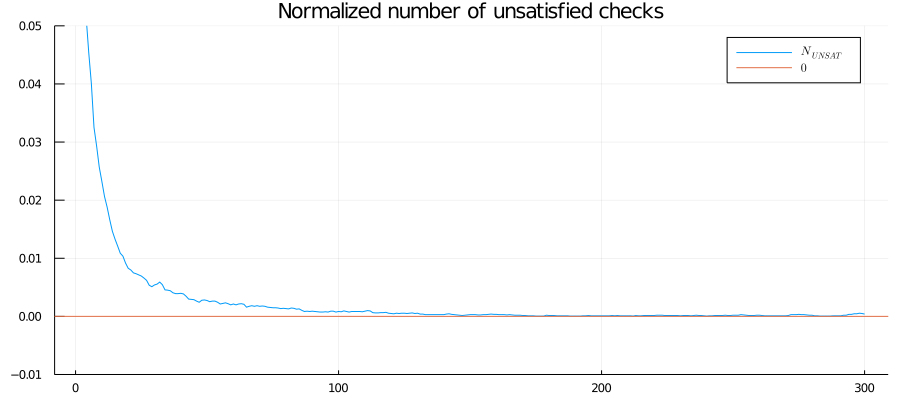

In [122]:
plot(1:algo.maxiter, parities[j]./n,label=L"N_{UNSAT}", ylims=(-0.01,0.05), size=(900,400))
hline!([0], label=L"0")
title!("Normalized number of unsatisfied checks")

In [99]:
println("Minimum number of unsatisfied checks across all iterations: ", minimum(parities[j]))

Minimum number of unsatisfied checks across all iterations: 6
